In [1]:
import sys, os
from typing import Any
import numpy as np
import tensorflow as tf
import logging

from pathlib import Path
from datetime import datetime

In [2]:
sys.path.append("..")

In [3]:
from adik.dataloaders.seq2point import MultitargetQuantileRegressionSeq2PointDataLoader

In [4]:
from adinilm.objs import DatasetProfile, ProfileHandler
from adinilm.src.tf_nilm.data_loader.seq2point_nilm import NILMSeq2PointDataset
from adinilm.utils.paths_manager import PROFILES_DIR, LOG_DIR, DATA_DIR
from adinilm.src.tf_nilm.losses.quantileloss import QuantileLoss 
from adinilm.src.tf_nilm.losses.multiactivationloss import MultiActivationLoss 
from adinilm.src.tf_nilm.models import simple_seq2point

In [11]:
SEQ_LEN = 100
BATCH_SIZE = 256
PROFILE_PATH = DATA_DIR / "NILMTK" / "processed"
BEST = True

In [12]:
data = NILMSeq2PointDataset(PROFILE_PATH / "val", seq_len=SEQ_LEN,
                        batch_size=BATCH_SIZE,
                        sequence_strategy= MultitargetQuantileRegressionSeq2PointDataLoader)


In [13]:
log_dir = "20240904-063900"
checkpoint_file = "best.keras" if BEST else "checkpoint.keras"

In [14]:
CHECKPOINT = LOG_DIR / "tf_nilm" / log_dir / "weights" / checkpoint_file

In [15]:
model = tf.keras.models.load_model(CHECKPOINT)

In [16]:
ret = model.evaluate(data, batch_size=BATCH_SIZE)

3374/3374 ━━━━━━━━━━━━━━━━━━━━ 144s 42ms/step - loss: 0.2349 - y1_output_accuracy: 0.9542


In [17]:
pred = model.predict(data)

3374/3374 ━━━━━━━━━━━━━━━━━━━━ 153s 45ms/step


In [23]:
pred[0].shape, pred[1].shape

((863744, 5, 2), (863744, 5, 5))

In [36]:
states_pred = np.apply_along_axis(lambda x : tf.argmax(x, axis=0), axis=2, arr=pred[0])

In [37]:
states_pred.shape

(863744, 5)

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

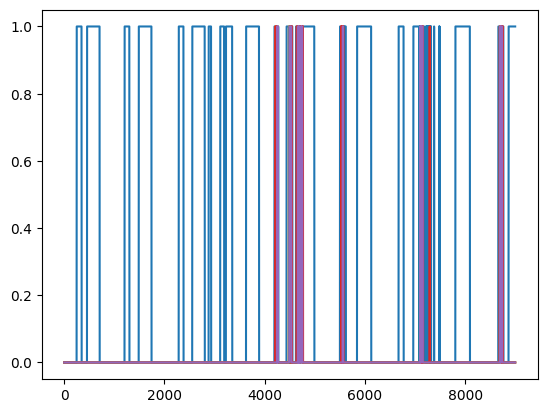

In [42]:
plt.plot(states_pred[:9000])

In [44]:
dliter = iter(data)

stat_list = []
for idx, (inp, lab) in enumerate(dliter):
        stat, pow = lab
        stat_list.append(stat)

In [47]:
stacked = np.vstack(stat_list)

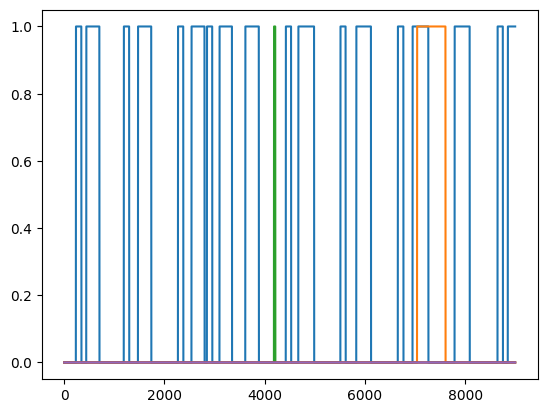

In [49]:
plt.plot(stacked[:9000])